# Image colorization using GANs

## 0. Python and Torch bureaucraty

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage.color import rgb2lab, lab2rgb

import time

import torch
from torch import nn
import torchvision

import tqdm

from unet import UNet

In [4]:
# To ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [5]:
# use the Metal backend if available (for Apple computers)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
# use CUDA if available (for NVIDIA cards)
elif torch.cuda.is_available():
    device = torch.device('cuda')
# otherwise, use the CPU
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [6]:
# utils functions to use LAB colorspace
def extract_lab_channels(image):
    lab_image = rgb2lab(image)
    l_channel = lab_image[:, :, 0] / 50 - 1
    ab_channels = lab_image[:, :, 1:] / 100
    return l_channel, ab_channels

def colorize_using_ab_channels(original_l_channel, ab_channels):
    l_channel = (original_l_channel + 1) * 50
    ab_channels = ab_channels * 100
    lab_image = np.concatenate([l_channel[:, :, np.newaxis], ab_channels], axis=-1)
    rgb_image = lab2rgb(lab_image)
    return rgb_image

## 1. Dataset creation

In [7]:
# import the Imagenette dataset and resize the images to 256x256
SIZE = 256
TRAIN_DATA_SIZE = 160
VAL_DATA_SIZE = 160

data_train_imagenette = torchvision.datasets.Imagenette("data", split='train', size="160px")
data_train_imagenette.transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((SIZE, SIZE), PIL.Image.BICUBIC),
    torchvision.transforms.ToTensor()
])

data_train_imagenette = torch.utils.data.Subset(data_train_imagenette, torch.arange(TRAIN_DATA_SIZE))


data_val_imagenette = torchvision.datasets.Imagenette("data", split='val', size="160px")
data_val_imagenette.transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((SIZE, SIZE), PIL.Image.BICUBIC),
    torchvision.transforms.ToTensor()
])

data_val_imagenette = torch.utils.data.Subset(data_val_imagenette, torch.arange(VAL_DATA_SIZE))

print(len(data_train_imagenette), data_train_imagenette[0][0].shape)
print(len(data_val_imagenette), data_val_imagenette[0][0].shape)

160 torch.Size([3, 256, 256])
160 torch.Size([3, 256, 256])


In [8]:
# constant indices for the L and AB channels
L_idx = 0
AB_idx = 1

# custom dataset class for LAB to RGB conversions
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx][0]
        
        # Convert the image to the LAB color space
        img_l, img_ab = extract_lab_channels(img.permute(1, 2, 0).numpy())

        img_l, img_ab = torch.tensor(img_l), torch.tensor(img_ab)

        img_l = img_l.unsqueeze(0)
        img_ab = img_ab.permute(2, 0, 1)

        # Returns the L channel (black and white) as the input 
        # and the AB channels (colors) as the target
        return img_l, img_ab

In [9]:
# sanity check by displaying the dimensions of the first batch
train_colorization_dataset = ColorizationDataset(data_train_imagenette)
train_dataloader = torch.utils.data.DataLoader(train_colorization_dataset, batch_size=16)

val_colorization_dataset = ColorizationDataset(data_val_imagenette)
val_dataloader = torch.utils.data.DataLoader(val_colorization_dataset, batch_size=16)

example = next(iter(val_dataloader))
print(len(example))
print(example[L_idx].shape, example[AB_idx].shape)

2
torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])


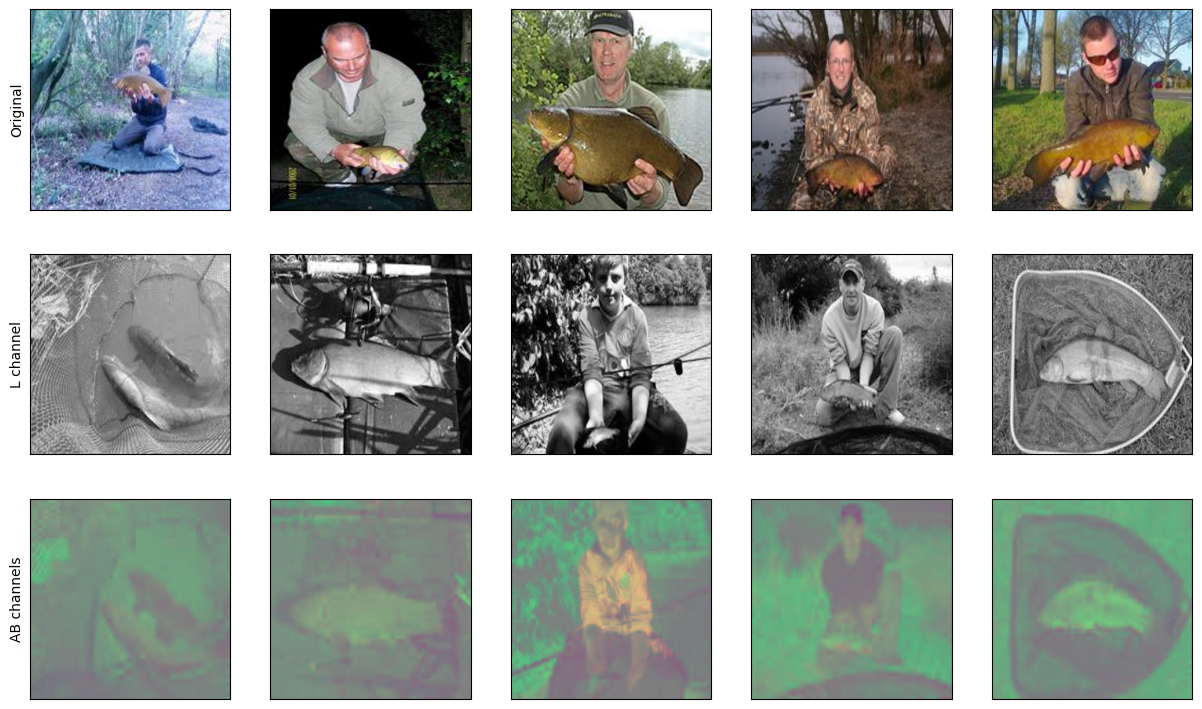

In [10]:
# sanity check by displaying a few images
example_batch = next(iter(train_dataloader))

fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    idx = np.random.randint(len(data_train_imagenette))
    original = data_train_imagenette[idx][0]
    source, target = example_batch[0][i], example_batch[1][i]

    if i == 0:
        axs[0][i].set_ylabel('Original')
        axs[1][i].set_ylabel('L channel')
        axs[2][i].set_ylabel('AB channels')
    
    axs[0][i].imshow(original.permute(1, 2, 0))
    axs[1][i].imshow(source[0], cmap='gray')
    axs[2][i].imshow((torch.cat((target.permute(1, 2, 0), torch.zeros((SIZE, SIZE, 1))), dim=-1)+ 1) / 2)

for ax in axs.flat:
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])

## (Difference between Grayscale and L channel of LAB colorspace)

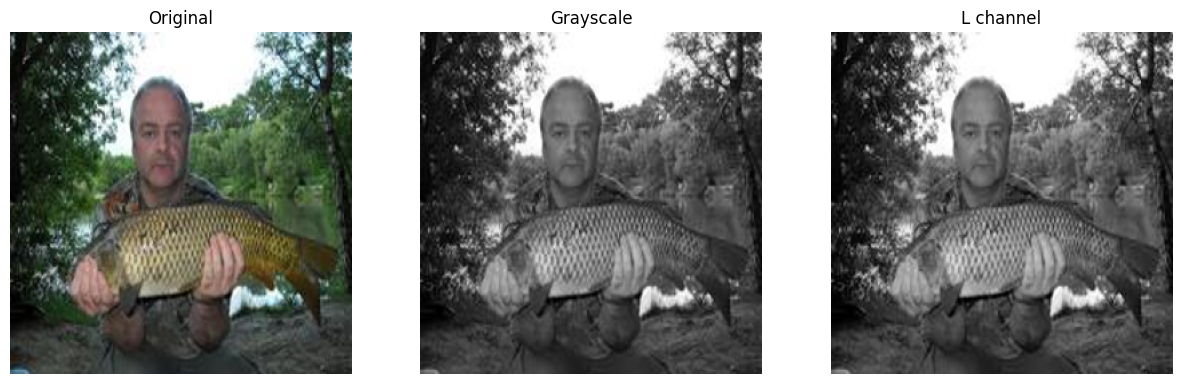

In [35]:
image = data_train_imagenette[np.random.randint(len(data_train_imagenette))][0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Grayscale")
plt.imshow(torchvision.transforms.Grayscale()(image).permute(1, 2, 0), cmap='gray')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("L channel")
plt.imshow(rgb2lab(image.permute(1, 2, 0).numpy())[:, :, 0], cmap='gray')

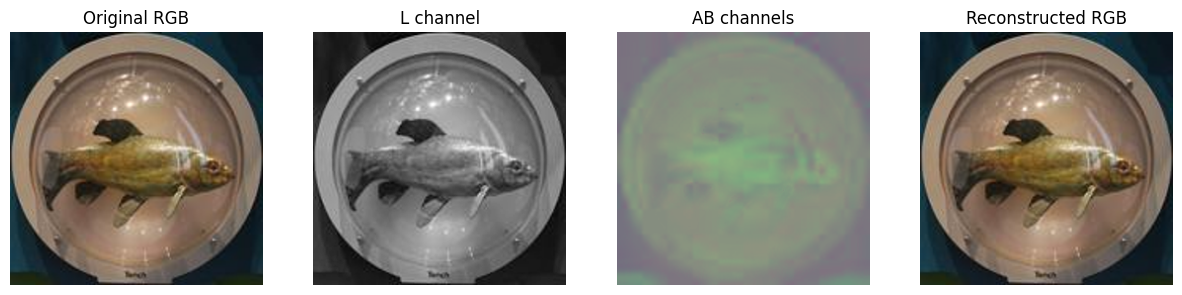

In [36]:
image = data_train_imagenette[np.random.randint(len(data_train_imagenette))][0]
l_channel, ab_channels = extract_lab_channels(image.permute(1, 2, 0).numpy())

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.axis('off')
plt.title("Original RGB")
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 4, 2)
plt.axis('off')
plt.title("L channel")
plt.imshow(l_channel, cmap='gray')

plt.subplot(1, 4, 3)
plt.axis('off')
plt.title("AB channels")
plt.imshow((np.concatenate((ab_channels, np.zeros((SIZE, SIZE, 1))), axis=-1) + 1) / 2)

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("Reconstructed RGB")
plt.imshow(colorize_using_ab_channels(l_channel, ab_channels))

## (Linear model)

In [11]:
data_train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)

In [12]:
def train_model(model, dataloader, epochs):
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1)
  loss_fn = nn.MSELoss()

  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
      inputs, targets = data
      inputs, targets = inputs.unsqueeze(1).to(device), targets.permute(0, 3, 1, 2).to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f"[TRAIN epoch {epoch}]: Loss: {running_loss/len(data_train)}")

In [13]:
train_model(model, data_train_loader, 4)

[TRAIN epoch 0]: Loss: 0.0007156511386856437
[TRAIN epoch 1]: Loss: 0.0006383840264752507
[TRAIN epoch 2]: Loss: 0.0006151586724445224
[TRAIN epoch 3]: Loss: 0.0006028115786612033


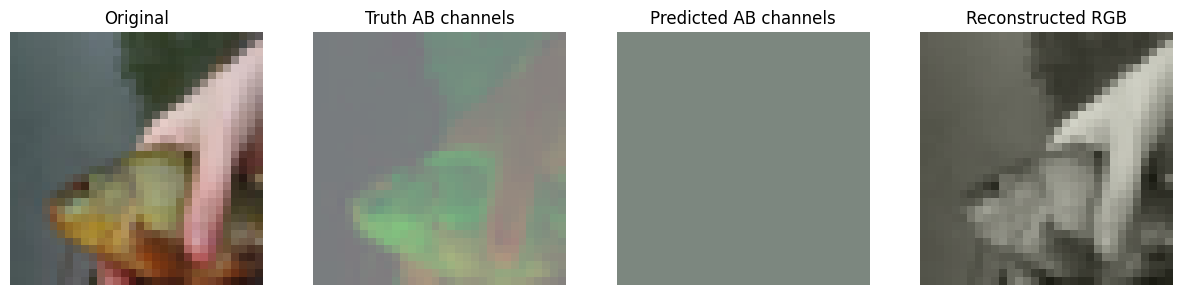

In [14]:
plt.figure(figsize=(15, 5))

predicted_ab_channels = model(torch.tensor(l_channel).unsqueeze(0).unsqueeze(0).to(device)).squeeze(0)

plt.subplot(1, 4, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 4, 2)
plt.axis('off')
plt.title("Truth AB channels")
plt.imshow((np.concatenate((ab_channels, np.zeros((SIZE, SIZE, 1))), axis=-1) + 1) / 2)

plt.subplot(1, 4, 3)
plt.axis('off')
plt.title("Predicted AB channels")
plt.imshow((torch.cat((predicted_ab_channels.permute(1, 2, 0), torch.zeros((SIZE, SIZE, 1)).to(device)), dim=-1).detach().cpu().numpy() + 1) / 2)

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("Reconstructed RGB")
plt.imshow(colorize_using_ab_channels(l_channel, predicted_ab_channels.permute(1, 2, 0).detach().cpu().numpy()))

In [9]:
# class UnetBlock(nn.Module):
#     def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
#         super().__init__()
#         self.outermost = outermost
#         if input_c is None: input_c = nf
#         downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
#         downrelu = nn.LeakyReLU(0.2, True)
#         downnorm = nn.BatchNorm2d(ni)
#         uprelu = nn.ReLU(True)
#         upnorm = nn.BatchNorm2d(nf)
        
#         if outermost:
#             upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1)
#             down = [downconv]
#             up = [uprelu, upconv, nn.Tanh()]
#             model = down + [submodule] + up
#         elif innermost:
#             upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
#             down = [downrelu, downconv]
#             up = [uprelu, upconv, upnorm]
#             model = down + up
#         else:
#             upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1, bias=False)
#             down = [downrelu, downconv, downnorm]
#             up = [uprelu, upconv, upnorm]
#             if dropout: up += [nn.Dropout(0.5)]
#             model = down + [submodule] + up
#         self.model = nn.Sequential(*model)
    
#     def forward(self, x):
#         if self.outermost:
#             return self.model(x)
#         else:
#             return torch.cat([x, self.model(x)], 1)

# class Unet(nn.Module):
#     def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
#         super().__init__()
#         unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
#         for _ in range(n_down - 5):
#             unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
#         out_filters = num_filters * 8
#         for _ in range(3):
#             unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
#             out_filters //= 2
#         self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
#     def forward(self, x):
#         return self.model(x)

## 2. Discriminator model

In [11]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
            for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [12]:
# sanity check for the output dimensions
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, SIZE, SIZE) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

## 3. Loss functions

In [13]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## 4. Full model

In [14]:
def init_weights(net, gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    return net

def init_model(model):
    model = model.to(device)
    model = init_weights(model)
    return model

In [21]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        self.lambda_L1 = lambda_L1
        
        if net_G is None: # first training
            self.net_G = init_model(UNet(n_channels=1, n_classes=2))
        else: # resume training
            self.net_G = net_G.to(device)

        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = torch.optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = torch.optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data[L_idx].to(device)
        self.ab = data[AB_idx].to(device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [22]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

model initialized with norm initialization
model initialized with norm initialization


 90%|█████████ | 9/10 [03:18<00:21, 21.85s/it]


Epoch 1/20
Iteration 10/10
loss_D_fake: 0.98506
loss_D_real: 0.97499
loss_D: 0.98003
loss_G_GAN: 0.98775
loss_G_L1: 11.62888
loss_G: 12.61662


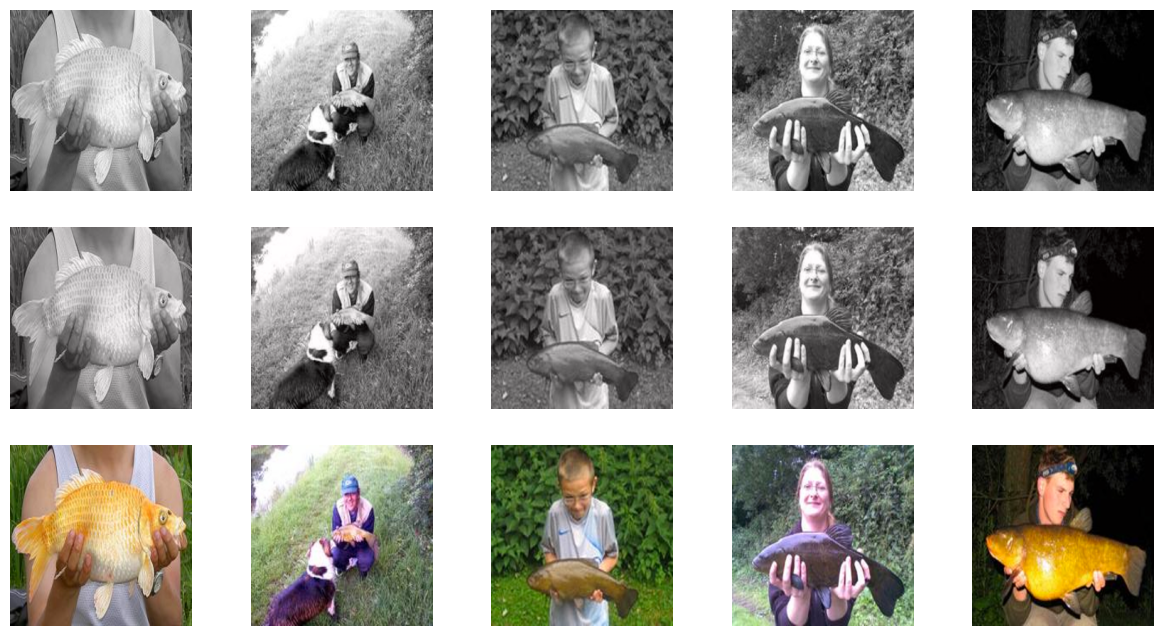

  0%|          | 0/10 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def train_model(model, train_dl, val_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0 # log the losses of the complete network
        for data in tqdm.tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data[L_idx].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
train_model(model, train_dataloader, val_dataloader, 20, display_every=10)